In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src/")
import numpy as np
import pandas as pd

extracted_features_dir = "../data/extracted_features/"
results_dir = "../data/results/"
sentiment_dir = "../data/evaluationscore/"
canonization_labels_dir = "../data/labels/"
lang = "eng"

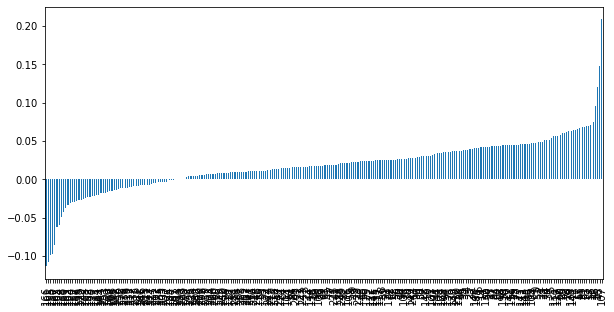

In [2]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.svm import SVR, SVC
import xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBRegressor
from copy import deepcopy
from scipy.stats import pearsonr
from utils import read_sentiment_scores, read_library_scores
from math import sqrt
get_ipython().run_line_magic("matplotlib", "inline") # %matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import statistics
import random
random.seed(9)

labels = read_sentiment_scores(sentiment_dir, canonization_labels_dir, lang)
library_scores = read_library_scores(sentiment_dir, canonization_labels_dir, lang)


In [3]:
labels

,book_name,y,c
1,Austen_Jane_Pride-and-Prejudice_1813,0.029731,3
2,Austen_Jane_Sense-and-Sensibility_1811,0.049103,3
3,Barrie_J-M_Auld-Licht-Idylls_1888,0.016107,3
4,Barrie_J-M_Sentimental-Tommy_1896,0.038327,3
5,Beerbohm_Max_Zuleika-Dobson_1911,0.053656,3
...,...,...,...
148,Wollstonecraft_Mary_Mary_1788,0.040233,3
170,Scott_Walter_The-Black-Dwarf_1816,-0.021840,2
177,Beckford_William_Vathek_1786,0.006286,2
234,Radcliffe_Ann_Udolpho_1794,0.004301,2


<AxesSubplot:>

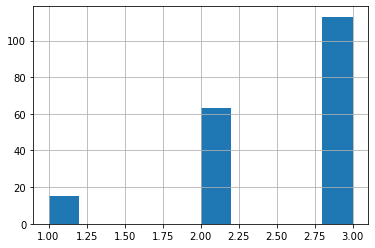

In [4]:
labels["c"].hist()

In [5]:
3 in labels["c"].values

True

191


<AxesSubplot:ylabel='Frequency'>

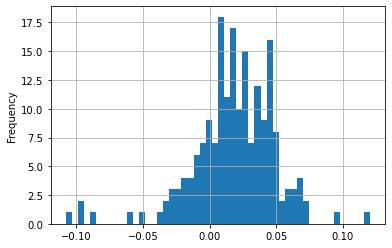

In [6]:
## Labels statistics
print(len(pd.unique(labels["book_name"]))) #197
# 254 labels, 197 different book_names -> 57 second/third... reviews
# 36 book_names with more than 1 label, these 36 book_names have 93 labels
# 93 = 36 first reviews + 57 second/third... reviews
# 6 texts have opposing reviews (13 reviews are opposing)
# 191 texts after aggregating (without opposing reviews)

labels["y"].plot.hist(grid=True, bins=50)

In [7]:
class Regression(object):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        assert isinstance(drop_columns_including, list)
        for i in drop_columns_including:
            assert isinstance(i, str)
        assert (dimensionality_reduction in ["k_best_f_reg_0_10", "k_best_mutual_info_0_10", "ss_pca_0_95"]) or (dimensionality_reduction is None)
        self._check_class_specific_assertions()
        
        self.language = language
        self.features = features
        self.labels = labels
        self.labels = self._prepare_labels()
        self.drop_columns_including = drop_columns_including
        self.dimensionality_reduction = dimensionality_reduction
        self.model_param = model_param
        self.model = model
        self.verbose = verbose

        if self.features == "book":
            self.df = deepcopy(book_df)
        elif self.features == "chunk":
            self.df = deepcopy(chunk_df)
        elif self.features == "chunk_and_copied_book":
            self.df = deepcopy(chunk_and_copied_book_df)
        elif self.features == "book_and_averaged_chunk":
            self.df = deepcopy(book_and_averaged_chunk_df)

        columns_before_drop = set(self.df.columns)
        if self.drop_columns_including:
            self.df = self.df[[column for column in self.df.columns if not self._drop_column(column)]].reset_index(drop=True)
        columns_after_drop = set(self.df.columns)
        if self.verbose:
            print(f"Dropped {len(columns_before_drop - columns_after_drop)} columns.")
            
    def _check_class_specific_assertions(self):
        assert model in ["xgboost", "svr", "lasso"]
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
    
    def _prepare_labels(self):
        return self.labels.drop(columns="c")

    def _drop_column(self, column):
        for string in self.drop_columns_including:
            if string in column:
                return True
        return False
    
    def _custom_pca(self, train_X):
        for i in range(5, train_X.shape[1], int((train_X.shape[1] - 5) / 10)):
            pca = PCA(n_components=i)
            new_train_X = pca.fit_transform(train_X)
            if pca.explained_variance_ratio_.sum() >= 0.95:
                break
        return new_train_X, pca

    def _select_features(self, train_X, train_y, validation_X):
        if self.dimensionality_reduction == "ss_pca_0_95":
            ss = StandardScaler()
            train_X = ss.fit_transform(train_X)
            validation_X = ss.transform(validation_X)
            train_X, pca = self._custom_pca(train_X)
            validation_X = pca.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_f_reg_0_10":
            k_best = SelectKBest(f_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_mutual_info_0_10":
            k_best = SelectKBest(mutual_info_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction is None:
            pass
        return train_X, validation_X
    
    def _impute(self, train_X, validation_X):
        imputer = KNNImputer()
        train_X = imputer.fit_transform(train_X)
        validation_X = imputer.transform(validation_X)
        return train_X, validation_X
    
    def _get_model(self, model_param, train_X=None, train_y=None, train_book_names=None, task_type=None):
        if self.model == "xgboost":
            if task_type == "binary_classification":
                is_classification = True
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1], y=train_y.astype(int).tolist())))
            elif task_type == "multiclass_classification":
                is_classification = True
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
            elif task_type == "regression":
                is_classification = False
            else:
                raise Exception("Not a valid task_type")
            
            def feval(preds, train_data):
                labels = train_data.get_label()
                if is_classification:
                    labels = labels.astype(int)
                    preds = preds.argmax(axis=1).astype(int)
                    if task_type == "binary_classification":
                        return 'acc', accuracy_score(labels, preds)
                    elif task_type == "multiclass_classification":
                        return 'f1', f1_score(labels, preds, average='macro')
                else:
                    return 'rmse', np.sqrt(mean_squared_error(labels, preds))
            
            if is_classification:
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
            else:
                dtrain = xgboost.DMatrix(train_X, label=train_y)
            results = []
            df = np.hstack((train_book_names, train_X))
            df = pd.DataFrame(df, columns=["book_name"] + [f"col_{i}" for i in range(train_X.shape[1])])
            for max_depth in [2, 4, 6, 8]:
                for learning_rate in [None, 0.01, 0.033, 0.1]:
                    for colsample_bytree in [0.33, 0.60, 0.75]:
                        if task_type == "multiclass_classification":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"}
                        elif task_type == "binary_classification":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1, "objective": "multi:softmax", "num_class": 2, "eval_metric": "mlogloss"}
                        elif task_type == "regression":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1}
                        else:
                            raise Exception("Not a valid task_type")
                        cv_results = xgboost.cv(
                                        params,
                                        dtrain,
                                        num_boost_round=99999,
                                        seed=42,
                                        nfold=5,
                                        folds=self._split_booknames(df, 5, return_indices=True),
                                        feval=feval,
                                        maximize=is_classification, # if classification, maximize f1/acc score.
                                        early_stopping_rounds=10,
                                        verbose_eval=False)

                        if task_type == "binary_classification":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-acc-mean"]
                        elif task_type == "multiclass_classification":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-f1-mean"]
                        elif task_type == "regression":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-rmse-mean"]
                        else:
                            raise Exception("Not a valid task_type")
                        num_boost_round = len(cv_results)
                        if task_type == "multiclass_classification":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"})
                        elif task_type == "binary_classification":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score, "objective": "multi:softmax", "num_class": 2, "eval_metric": "mlogloss"})
                        elif task_type == "regression":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score})
                        else:
                            raise Exception("Not a valid task_type")
            best_parameters = sorted(results, key=lambda x: x["nested_cv_score"], reverse=is_classification)[0]
            return best_parameters
        elif self.model == "svr":
            return SVR(C=model_param)
        elif self.model == "lasso":
            return Lasso(alpha=model_param)
        elif self.model == "svc":
            return SVC(C=model_param)
        
    def _split_booknames(self, df, nr_splits, return_indices=False):
        """
        Distribute book names over splits.
        All works of an author are in the same split.
        """
        book_names = df["book_name"].unique()
        authors = []
        booknames_authors_mapping = {}

        #Get authors
        for book_name in book_names:
            author = "_".join(book_name.split("_")[:2])
            authors.append(author)
            if author in booknames_authors_mapping:
                booknames_authors_mapping[author].append(book_name)
            else:
                booknames_authors_mapping[author] = []
                booknames_authors_mapping[author].append(book_name)
        #Distribute authors over splits so that each split has approximately the same number of books
        works_per_author = Counter(authors)
        goal_sum = round(len(book_names)/nr_splits)
        tolerance = 0.03
        lower_threshold = goal_sum - round(tolerance*goal_sum)
        upper_threshold = goal_sum + round(tolerance*goal_sum)
        author_splits = []
        popped_dict = {}

        for i in range (0, nr_splits-1):
            works_in_split = 0
            split = []
            curr_author_workcount = 0

            # take values from popped dict first
            if bool(popped_dict):  
                popped = []
                for curr_author, curr_author_workcount in popped_dict.items():
                    # leave item in popped dict if value is too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        continue
                    else:
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                for current_author in popped:
                    del popped_dict[current_author]
            while works_in_split < upper_threshold:
                if bool(works_per_author):
                    curr_author = random.choice(list(works_per_author.keys()))
                    curr_author_workcount = works_per_author.pop(curr_author)
                    # Put values into separate dict if too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        popped_dict[curr_author] = curr_author_workcount
                    else:
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                else:
                    #ignore upper threshold
                    popped = []
                    for curr_author, curr_author_workcount in popped_dict.items():
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                    for current_author in popped:
                        del popped_dict[current_author]

            author_splits.append(split)
        #Create last split directly from remaining dict
        works_in_last_split = sum(works_per_author.values()) + sum(popped_dict.values())
        split = list(works_per_author.keys()) + list(popped_dict.keys())
        author_splits.append(split)

        if not return_indices:
            #Map author splits to book names
            book_splits = []
            for author_split in author_splits:
                book_split = []
                for author in author_split:
                    book_split.extend(booknames_authors_mapping[author])
                book_splits.append(book_split)
        else:
            book_name_idx_mapping = dict((book_name, index) for index, book_name in enumerate(book_names))
            book_splits = []
            for author_split in author_splits:
                test_split = []
                for author in author_split:
                    test_split.extend([book_name_idx_mapping[book_name] for book_name in booknames_authors_mapping[author]])
                train_split = list(set(book_name_idx_mapping.values()) - set(test_split))
                book_splits.append((train_split, test_split))
        return book_splits
    
    def _get_pvalue(self, validation_corr_pvalues):
        # Harmonic mean p-value
        denominator = sum([1/x for x in validation_corr_pvalues])
        mean_p_value = len(validation_corr_pvalues)/denominator
        return mean_p_value
    
    def _combine_df_labels(self, df):
        #Average of sentiscores per book
        df = df.merge(right=self.labels, on="book_name", how="inner", validate="many_to_one")
        return df
    
    def run(self):
        all_predictions = []
        all_labels = []

        train_mses = []
        train_maes = []
        train_r2s = []
        train_corrs = []
        
        validation_mses = []
        validation_maes = []
        validation_r2s = []
        validation_corrs = []
        validation_corr_pvalues = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split = self._split_booknames(df, 5)
        all_validation_books = []

        for index, split in enumerate(book_names_split):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="regression")
                dtrain = xgboost.DMatrix(train_X, label=train_y)
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
                
                print("train preds:", model.predict(xgboost.DMatrix(train_X)))
                print("validation preds:", model.predict(xgboost.DMatrix(validation_X)))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)
            
            train_books = train_books.groupby("book_name").mean()
            validation_books = validation_books.groupby("book_name").mean()
            all_validation_books.append(validation_books.reset_index())
            
            train_y = train_books["y"].tolist()
            train_yhat = train_books["yhat"].tolist()
            validation_y = validation_books["y"].tolist()
            validation_yhat = validation_books["yhat"].tolist()
            
            all_labels.extend(validation_y)
            all_predictions.extend(validation_yhat)
            
            train_mse = mean_squared_error(train_y, train_yhat)
            train_mae = mean_absolute_error(train_y, train_yhat)
            train_r2 = r2_score(train_y, train_yhat)
            train_corr = pearsonr(train_y, train_yhat)[0]
            
            validation_mse = mean_squared_error(validation_y, validation_yhat)
            validation_mae = mean_absolute_error(validation_y, validation_yhat)
            validation_r2 = r2_score(validation_y, validation_yhat)
            validation_corr = pearsonr(validation_y, validation_yhat)[0]
            p_value = pearsonr(validation_y, validation_yhat)[1]
            
            train_mses.append(train_mse)
            train_maes.append(train_mae)
            train_r2s.append(train_r2)
            train_corrs.append(train_corr)
            
            validation_mses.append(validation_mse)
            validation_maes.append(validation_mae)
            validation_r2s.append(validation_r2)
            validation_corrs.append(validation_corr)
            validation_corr_pvalues.append(p_value)
            
            if self.verbose:
                print(f"Fold: {index+1}, TrainMSE: {np.round(train_mse, 3)}, TrainMAE: {np.round(train_mae, 3)}, ValMSE: {np.round(validation_mse, 3)}, ValMAE: {np.round(validation_mae, 3)}, ValR2: {np.round(validation_r2, 3)}, ValCorr: {np.round(validation_corr, 3)}")
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)
        
        # Save y and y_pred for examples
        pd.concat(all_validation_books).to_csv(results_dir + "/y-yhat-" + self.language + "-" + ".csv", index=False)
        
        mean_train_mse = np.mean(train_mses)
        mean_train_rmse = np.mean([sqrt(x) for x in train_mses])
        mean_train_mae = np.mean(train_maes)
        mean_train_r2 = np.mean(train_r2s)
        mean_train_corr = np.mean(train_corrs)
        
        mean_validation_mse = np.mean(validation_mses)
        mean_validation_rmse = np.mean([sqrt(x) for x in validation_mses])
        mean_validation_mae = np.mean(validation_maes)
        mean_validation_r2 = np.mean(validation_r2s)
        mean_validation_corr = np.mean(validation_corrs)
        mean_p_value = self._get_pvalue(validation_corr_pvalues)
        
        if self.verbose:
            print(f"""TrainMSE: {np.round(mean_train_mse, 3)}, TrainRMSE: {np.round(mean_train_rmse, 3)}, TrainMAE: {np.round(mean_train_mae, 3)}, TrainR2: {np.round(mean_train_r2, 3)}, TrainCorr: {np.round(mean_train_corr, 3)}, ValMSE: {np.round(mean_validation_mse, 3)}, ValRMSE: {np.round(mean_validation_rmse, 3)}, ValMAE: {np.round(mean_validation_mae, 3)}, ValR2: {np.round(mean_validation_r2, 3)}, ValCorr: {np.round(mean_validation_corr, 3)}, ValCorrPValue: {np.round(mean_p_value, 3)}""")
            print("\n---------------------------------------------------\n")
            plt.figure(figsize=(4,4))
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.xlim([0,1])
            plt.ylim([0,1])

            plt.scatter(all_labels, all_predictions, s=6)
            plt.xlabel("Canonization Scores", fontsize=20)
            plt.ylabel("Predicted Scores", fontsize=20)
            plt.savefig(results_dir + lang + "-" + self.model + "-" + str(self.dimensionality_reduction) 
            + "-" + self.features + "-" + "-" + "param" + str(self.model_param) + "-" + ".png", 
            dpi=400, bbox_inches="tight")
    
            plt.show();
        return mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value


In [8]:
'''
Classification into reviewed/not reviewed
'''

class TwoclassClassification(Regression):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

    def _check_class_specific_assertions(self):
        assert model in ["svc", "xgboost"]
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
        
    def _prepare_labels(self):
        labels = self.labels.drop(columns="y").rename(columns={"c":"y"})
        return labels
        
    def _combine_df_labels(self, df):
        #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
        agg_labels = self.labels[["book_name"]].drop_duplicates()
        agg_labels["y"] = 1
        df = df.merge(right=agg_labels, on="book_name", how="left", validate="many_to_one")
        df["y"] = df["y"].fillna(value=0)
        #Select books written after year of first review)
        year = df["book_name"].str.replace('-', '_').str.split('_').str[-1].astype('int64')
        df = df.loc[year>=min(year)]
        return df
    
    def _get_sample_weights(self, df):
        # Weights for calculating accuracy 
        chunks_per_book = df["book_name"].value_counts(sort=False).rename('chunks_per_book')
        chunks_per_book = chunks_per_book.reset_index().rename(columns={"index":'book_name'})
        chunks_per_book["chunks_per_book"] = 1/chunks_per_book["chunks_per_book"]
        df = df.merge(right=chunks_per_book, how="left", on="book_name")
        sample_weights = df["chunks_per_book"].tolist()
        return sample_weights
    
    def _aggregate_chunk_predictions(self, df):
        g = df.groupby("book_name")
        
        # Majority vote
        # If one value is more common, assign it to every chunk
        # Therefore, accuracy is either 0 or 1
        # If both values are equally likely, leave them unchanged, and accuracy is 0.5
        def _get_mode_accuracy(group):
            counts = group["yhat"].value_counts()
            if len(counts) == 1:
                mode_acc = counts.index[0]
            else:
                mode_acc = 0.5
            return mode_acc
        mode_accs = g.apply(_get_mode_accuracy).rename("mode_acc").reset_index()
        mode_acc = mode_accs["mode_acc"].mean()
        
        # Average accuracy within book
        book_acc = g.apply(lambda group: accuracy_score(group["y"], group["yhat"])).mean()
        #Accuracy when each chunk is treated as single document
        chunk_acc = accuracy_score(df["y"], df["yhat"])#, sample_weight = self._get_sample_weights(df))
        return {"mode_acc": mode_acc, "book_acc": book_acc, "chunk_acc": chunk_acc}
    
    def _split_booknames_stratified(self, df, nr_splits, return_indices=False):
        label_splits = []
        combined_splits = []
        # Split df into folds for each label individualls
        df_by_labels = df.groupby("y")
        for name, group in df_by_labels:
            split = self._split_booknames(group, 5)
            label_splits.append(split)
        # Combine splits so that one splits combines splits for all labels
        for fold in range(0, nr_splits):
            combined_split = []
            for label in range(0, len(pd.unique(df["y"]))):
                label_split = label_splits[label]
                fold_split = label_split[fold]
                combined_split.extend(fold_split)
            combined_splits.append(combined_split)
        return combined_splits                            
                             
    def run(self):
        train_accs = []
        validation_accs = []
        df = self.df
        df = self._combine_df_labels(df)
        book_names_split_stratified = self._split_booknames_stratified(df, nr_splits=5, return_indices=False)
        all_validation_books = []

        for index, split in enumerate(book_names_split_stratified):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            print("class distribution over dfs")
            print(train_df["y"].value_counts())
            print(validation_df["y"].value_counts())
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="binary_classification")
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1], y=train_y.astype(int).tolist())))
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)

            train_acc = self._aggregate_chunk_predictions(train_books)
            validation_acc = self._aggregate_chunk_predictions(validation_books)
            
            all_validation_books.append(validation_books)
            
            train_accs.append(train_acc)
            validation_accs.append(validation_acc)
        
        # Save y and y_pred for examples
        all_validation_books = pd.concat(all_validation_books)
        all_validation_books.to_csv(results_dir + "/valiationbooks-class-" + self.language + "-" + ".csv", index=False)
        
        print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
        print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))

        train_accs = pd.DataFrame(train_accs)
        validation_accs = pd.DataFrame(validation_accs)

        mean_train_mode_acc = train_accs["mode_acc"].mean()
        mean_train_book_acc = train_accs["book_acc"].mean()
        mean_train_chunk_acc = train_accs["chunk_acc"].mean()
        mean_validation_mode_acc = validation_accs["mode_acc"].mean()
        mean_validation_book_acc = validation_accs["book_acc"].mean()
        mean_validation_chunk_acc = validation_accs["chunk_acc"].mean()
        print(mean_train_mode_acc, mean_train_book_acc, mean_train_chunk_acc)
        print(mean_validation_mode_acc, mean_validation_book_acc, mean_validation_chunk_acc)

        return mean_train_book_acc, mean_validation_book_acc

In [9]:
# ''' 
# Classification into in library/not in library
# '''

# class LibraryClassification(TwoclassClassification):
#     def _prepare_labels(self):
#         return self.labels

In [10]:
'''
Classification into not reviewed/negative/not classified/positive
'''

class MulticlassClassification(TwoclassClassification):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

    def _check_class_specific_assertions(self):
        assert model in ["svc", "xgboost"]
        assert features in ["book", "book_and_averaged_chunk"]#, "chunk_and_copied_book", "chunk"]
                
    def _combine_df_labels(self, df):
        #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
        df = df.merge(right=self.labels, on="book_name", how="left", validate="many_to_one")
        df["y"] = df["y"].fillna(value=0)
        #Select books written after year of first review
        year = df["book_name"].str.replace('-', '_').str.split('_').str[-1].astype('int64')
        df = df.loc[year>=min(year)]
        return df
    
    def _evaluate_predictions(self, df):
        score = f1_score(df["y"], df["yhat"], average='macro')
        return score
            
        
    def run(self):
        train_f1s = []
        validation_f1s = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split_stratified = self._split_booknames_stratified(df, nr_splits=5, return_indices=False)
        all_validation_books = []

        for index, split in enumerate(book_names_split_stratified):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            print("class distribution over dfs")
            print(train_df["y"].value_counts())
            print(validation_df["y"].value_counts())
            #print(train_df.loc[train_df["y"]==1])
            print(validation_df.loc[validation_df["y"]==1])
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="multiclass_classification")
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)
            
            train_f1 = self._evaluate_predictions(train_books)
            validation_f1 = self._evaluate_predictions(validation_books)
            all_validation_books.append(validation_books)
            
            train_f1s.append(train_f1)
            validation_f1s.append(validation_f1)
            if self.verbose:
                print(f"Fold: {index+1}, TrainF1: {np.round(train_f1, 3)}, ValF1: {np.round(validation_f1, 3)}")
        
        # Save y and y_pred for examples
        all_validation_books = pd.concat(all_validation_books)
        all_validation_books.to_csv(results_dir + "/valiationbooks-class-" + self.language + "-" + ".csv", index=False)
        
        print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
        print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))

        mean_train_f1 = statistics.mean(train_f1s)
        mean_validation_f1 = statistics.mean(validation_f1s)
        
        if self.verbose:
            print(f"""TrainF1: {np.round(mean_train_f1, 3)}, ValidationF1: {np.round(mean_validation_f1, 3)}""")
            print("\n---------------------------------------------------\n")
        return mean_train_f1, mean_validation_f1

In [11]:
### Cross-validation

# Feature split
complexity_features = []

# All parameters
models = ["svr", "lasso", "xgboost", "svc"]
model_params = {"svr": [1], "lasso": [1, 4], "xgboost": [None], "svc": [0.1, 1, 10, 100, 1000, 10000]} #
dimensionality_reduction = ["ss_pca_0_95", 'k_best_f_reg_0_10', 'k_best_mutual_info_0_10', [None]]
features = ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]

# Which parameters to use
regression_params = {"model": ["xgboost"], "dimensionality_reduction": dimensionality_reduction[-1], "features": features}
testing_params = {"model": models[3], "dimensionality_reduction": dimensionality_reduction[-1], 
                  "features": ["book"]}
twoclass_params = {"model": ["svc", "xgboost"], "dimensionality_reduction": dimensionality_reduction[-1], 
                  "features": ["book", "book_and_averaged_chunk", "chunk", "chunk_and_copied_book"]}
multiclass_params = {"model": ["svc", "xgboost"], "dimensionality_reduction": dimensionality_reduction[-1],
                     "features": ["book", "book_and_averaged_chunk"]}

book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
book_df = drop_default_columns(book_df, drop_default_columns_including)
book_and_averaged_chunk_df = drop_default_columns(book_and_averaged_chunk_df, drop_default_columns_including)
chunk_df = drop_default_columns(chunk_df, drop_default_columns_including)
chunk_and_copied_book_df = drop_default_columns(chunk_and_copied_book_df, drop_default_columns_including)

print(len(book_df.columns), len(book_and_averaged_chunk_df.columns),len(chunk_df.columns),len(chunk_and_copied_book_df.columns),)

len(list(book_and_averaged_chunk_df.columns))

for i in list(book_and_averaged_chunk_df.columns):
    print(i)

In [14]:
'''
Run two-class classification
'''
results = []
param_dict = "twoclass" #"twoclass"
for lang in [lang]:
    if param_dict == "testing":
        param_dir = testing_params
    elif param_dict == "twoclass":
        param_dir = twoclass_params
    elif param_dict == "multiclass":
        param_dir = multiclass_params
    elif param_dict == "full_cv":
        param_dir = full_cv_params
    elif param_dict == "language_specific":
        if lang == "eng":
            param_dir = eng_params
        else: 
            param_dir = ger_params
    
    #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
    book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
    book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
    chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
    chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")

    for model in [] + param_dir['model']:
        print(model)
        model_param = model_params[model]
        for model_param in model_param:
            for dimensionality_reduction in param_dir["dimensionality_reduction"]:
                for features in param_dir["features"]:
                    for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
                        experiment = TwoclassClassification(
                            language=lang,
                            features=features,
                            drop_columns_including=drop_columns_including,
                            dimensionality_reduction=dimensionality_reduction,
                            model_param=model_param,
                            model=model,
                            verbose=True
                        )
                        mean_train_book_acc, mean_validation_book_acc = experiment.run()
                        print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param, mean_train_book_acc, mean_validation_book_acc)
                        results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_book_acc, mean_validation_book_acc))

results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
"dimensionality_reduction", "model_param", "mean_train_book_acc", "mean_validation_book_acc"])
results_df.to_csv(results_dir + lang + '_' + param_dict + "_" +"xgboost_nested_cv" + ".csv", index=False)


svc
Dropped 300 columns.
class distribution over dfs
0.0    333
1.0    154
Name: y, dtype: int64
0.0    82
1.0    37
Name: y, dtype: int64
class distribution over dfs
0.0    332
1.0    152
Name: y, dtype: int64
0.0    83
1.0    39
Name: y, dtype: int64
class distribution over dfs
0.0    334
1.0    154
Name: y, dtype: int64
0.0    81
1.0    37
Name: y, dtype: int64
class distribution over dfs
0.0    334
1.0    154
Name: y, dtype: int64
0.0    81
1.0    37
Name: y, dtype: int64
class distribution over dfs
0.0    327
1.0    150
Name: y, dtype: int64
0.0    88
1.0    41
Name: y, dtype: int64
[[415   0]
 [191   0]]
Predicted  0.0  All
True               
0.0        415  415
1.0        191  191
All        606  606
0.0 0.684823139504149 0.684823139504149
0.0 0.6848910795344845 0.6848910795344845
eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 0.1 0.684823139504149 0.6848910795344845
Dropped 330 columns.
class distribution over dfs
0.0    

[[3290 3859]
 [1979 5018]]
Predicted   0.0   1.0    All
True                        
0.0        3290  3859   7149
1.0        1979  5018   6997
All        5269  8877  14146
0.5542882170633269 0.5150637464533405 0.6153426588759732
0.5672497763481837 0.5062035981002778 0.5880355216443052
eng svc chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 0.1 0.5150637464533405 0.5062035981002778
Dropped 868 columns.
class distribution over dfs
1.0    5804
0.0    5247
Name: y, dtype: int64
0.0    1902
1.0    1193
Name: y, dtype: int64
class distribution over dfs
0.0    6629
1.0    5471
Name: y, dtype: int64
1.0    1526
0.0     520
Name: y, dtype: int64
class distribution over dfs
1.0    5883
0.0    5260
Name: y, dtype: int64
0.0    1889
1.0    1114
Name: y, dtype: int64
class distribution over dfs
0.0    5911
1.0    5462
Name: y, dtype: int64
1.0    1535
0.0    1238
Name: y, dtype: int64
class distribution over dfs
0.0    5549
1.0    5368
Name: y, dtype:

class distribution over dfs
0.0    332
1.0    153
Name: y, dtype: int64
0.0    83
1.0    38
Name: y, dtype: int64
class distribution over dfs
0.0    332
1.0    150
Name: y, dtype: int64
0.0    83
1.0    41
Name: y, dtype: int64
[[415   0]
 [191   0]]
Predicted  0.0  All
True               
0.0        415  415
1.0        191  191
All        606  606
0.0 0.6848226513545516 0.6848226513545516
0.0 0.684883530919494 0.684883530919494
eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 1 0.6848226513545516 0.684883530919494
Dropped 330 columns.
class distribution over dfs
0.0    334
1.0    152
Name: y, dtype: int64
0.0    81
1.0    39
Name: y, dtype: int64
class distribution over dfs
0.0    334
1.0    153
Name: y, dtype: int64
0.0    81
1.0    38
Name: y, dtype: int64
class distribution over dfs
0.0    334
1.0    153
Name: y, dtype: int64
0.0    81
1.0    38
Name: y, dtype: int64
class distribution over dfs
0.0    334
1.0    154
Name: y, dty

class distribution over dfs
0.0    6171
1.0    5555
Name: y, dtype: int64
1.0    1442
0.0     978
Name: y, dtype: int64
class distribution over dfs
0.0    6201
1.0    5655
Name: y, dtype: int64
1.0    1342
0.0     948
Name: y, dtype: int64
class distribution over dfs
1.0    5616
0.0    5129
Name: y, dtype: int64
0.0    2020
1.0    1381
Name: y, dtype: int64
class distribution over dfs
1.0    5381
0.0    5378
Name: y, dtype: int64
0.0    1771
1.0    1616
Name: y, dtype: int64
[[3454 3695]
 [1912 5085]]
Predicted   0.0   1.0    All
True                        
0.0        3454  3695   7149
1.0        1912  5085   6997
All        5366  8780  14146
0.5397727322511641 0.5248497333555585 0.617610588211368
0.5403103644492616 0.5179903116301748 0.605467963052069
eng svc chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 1 0.5248497333555585 0.5179903116301748
Dropped 868 columns.
class distribution over dfs
0.0    6273
1.0    5663
Name: y, dtyp

class distribution over dfs
0.0    334
1.0    154
Name: y, dtype: int64
0.0    81
1.0    37
Name: y, dtype: int64
class distribution over dfs
0.0    334
1.0    154
Name: y, dtype: int64
0.0    81
1.0    37
Name: y, dtype: int64
class distribution over dfs
0.0    334
1.0    153
Name: y, dtype: int64
0.0    81
1.0    38
Name: y, dtype: int64
class distribution over dfs
0.0    324
1.0    149
Name: y, dtype: int64
0.0    91
1.0    42
Name: y, dtype: int64
[[347  68]
 [124  67]]
Predicted  0.0  1.0  All
True                    
0.0        347   68  415
1.0        124   67  191
All        471  135  606
0.2045990843908843 0.7450995117145174 0.7450995117145174
0.2285144566301097 0.6831318075847644 0.6831318075847644
eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 10 0.7450995117145174 0.6831318075847644
Dropped 378 columns.
class distribution over dfs
0.0    334
1.0    154
Name: y, dtype: int64
0.0    81
1.0    37
Name: y, dtype: int

class distribution over dfs
1.0    5589
0.0    5425
Name: y, dtype: int64
0.0    1724
1.0    1408
Name: y, dtype: int64
[[3391 3758]
 [2299 4698]]
Predicted   0.0   1.0    All
True                        
0.0        3391  3758   7149
1.0        2299  4698   6997
All        5690  8456  14146
0.5139695274435804 0.5340488728672073 0.6191614515298656
0.5342751672998722 0.5036439451136269 0.582396616474676
eng svc chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 10 0.5340488728672073 0.5036439451136269
Dropped 868 columns.
class distribution over dfs
1.0    5743
0.0    5422
Name: y, dtype: int64
0.0    1727
1.0    1254
Name: y, dtype: int64
class distribution over dfs
0.0    5754
1.0    5435
Name: y, dtype: int64
1.0    1562
0.0    1395
Name: y, dtype: int64
class distribution over dfs
0.0    6005
1.0    5640
Name: y, dtype: int64
1.0    1357
0.0    1144
Name: y, dtype: int64
class distribution over dfs
1.0    5502
0.0    5139
Name: y, dt

class distribution over dfs
0.0    330
1.0    152
Name: y, dtype: int64
0.0    85
1.0    39
Name: y, dtype: int64
class distribution over dfs
0.0    334
1.0    154
Name: y, dtype: int64
0.0    81
1.0    37
Name: y, dtype: int64
class distribution over dfs
0.0    330
1.0    152
Name: y, dtype: int64
0.0    85
1.0    39
Name: y, dtype: int64
[[318  97]
 [ 91 100]]
Predicted  0.0  1.0  All
True                    
0.0        318   97  415
1.0         91  100  191
All        409  197  606
0.27024392485315857 0.7594757661457276 0.7594757661457276
0.324528306006306 0.6895988216938853 0.6895988216938853
eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 100 0.7594757661457276 0.6895988216938853
Dropped 378 columns.
class distribution over dfs
0.0    334
1.0    154
Name: y, dtype: int64
0.0    81
1.0    37
Name: y, dtype: int64
class distribution over dfs
0.0    334
1.0    153
Name: y, dtype: int64
0.0    81
1.0    38
Name: y, dtype: in

class distribution over dfs
0.0    6215
1.0    5202
Name: y, dtype: int64
1.0    1795
0.0     934
Name: y, dtype: int64
[[3281 3868]
 [1995 5002]]
Predicted   0.0   1.0    All
True                        
0.0        3281  3868   7149
1.0        1995  5002   6997
All        5276  8870  14146
0.536976797879716 0.528950120958321 0.6171952097746699
0.5606027539501311 0.5001027689459434 0.5740264755789994
eng svc chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 100 0.528950120958321 0.5001027689459434
Dropped 868 columns.
class distribution over dfs
1.0    5630
0.0    5198
Name: y, dtype: int64
0.0    1951
1.0    1367
Name: y, dtype: int64
class distribution over dfs
0.0    5939
1.0    5768
Name: y, dtype: int64
1.0    1229
0.0    1210
Name: y, dtype: int64
class distribution over dfs
0.0    5847
1.0    5533
Name: y, dtype: int64
1.0    1464
0.0    1302
Name: y, dtype: int64
class distribution over dfs
0.0    5828
1.0    5467
Name: y, dty

class distribution over dfs
0.0    331
1.0    154
Name: y, dtype: int64
0.0    84
1.0    37
Name: y, dtype: int64
class distribution over dfs
0.0    334
1.0    154
Name: y, dtype: int64
0.0    81
1.0    37
Name: y, dtype: int64
class distribution over dfs
0.0    327
1.0    149
Name: y, dtype: int64
0.0    88
1.0    42
Name: y, dtype: int64
[[332  83]
 [ 97  94]]
Predicted  0.0  1.0  All
True                    
0.0        332   83  415
1.0         97   94  191
All        429  177  606
0.28384780865693726 0.7765126886942157 0.7765126886942157
0.290588338517279 0.705594907222751 0.705594907222751
eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 1000 0.7765126886942157 0.705594907222751
Dropped 378 columns.
class distribution over dfs
0.0    333
1.0    152
Name: y, dtype: int64
0.0    82
1.0    39
Name: y, dtype: int64
class distribution over dfs
0.0    330
1.0    154
Name: y, dtype: int64
0.0    85
1.0    37
Name: y, dtype: int6

class distribution over dfs
0.0    6485
1.0    5547
Name: y, dtype: int64
1.0    1450
0.0     664
Name: y, dtype: int64
class distribution over dfs
1.0    5746
0.0    5242
Name: y, dtype: int64
0.0    1907
1.0    1251
Name: y, dtype: int64
class distribution over dfs
1.0    5697
0.0    5142
Name: y, dtype: int64
0.0    2007
1.0    1300
Name: y, dtype: int64
[[3393 3756]
 [2030 4967]]
Predicted   0.0   1.0    All
True                        
0.0        3393  3756   7149
1.0        2030  4967   6997
All        5423  8723  14146
0.5481775441729384 0.5184348223235907 0.6206547844012367
0.5530389813120744 0.5091504229354531 0.5935647905531264
eng svc chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 1000 0.5184348223235907 0.5091504229354531
Dropped 868 columns.
class distribution over dfs
1.0    6047
0.0    5090
Name: y, dtype: int64
0.0    2059
1.0     950
Name: y, dtype: int64
class distribution over dfs
0.0    6559
1.0    5580
Name: y,

class distribution over dfs
0.0    334
1.0    153
Name: y, dtype: int64
0.0    81
1.0    38
Name: y, dtype: int64
class distribution over dfs
0.0    333
1.0    154
Name: y, dtype: int64
0.0    82
1.0    37
Name: y, dtype: int64
class distribution over dfs
0.0    334
1.0    153
Name: y, dtype: int64
0.0    81
1.0    38
Name: y, dtype: int64
class distribution over dfs
0.0    327
1.0    152
Name: y, dtype: int64
0.0    88
1.0    39
Name: y, dtype: int64
[[310 105]
 [ 92  99]]
Predicted  0.0  1.0  All
True                    
0.0        310  105  415
1.0         92   99  191
All        402  204  606
0.2895045470966465 0.8019135101273352 0.8019135101273352
0.33849785170296337 0.673883953994661 0.673883953994661
eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 10000 0.8019135101273352 0.673883953994661
Dropped 378 columns.
class distribution over dfs
0.0    334
1.0    152
Name: y, dtype: int64
0.0    81
1.0    39
Name: y, dtype: in

class distribution over dfs
0.0    6529
1.0    5722
Name: y, dtype: int64
1.0    1275
0.0     620
Name: y, dtype: int64
class distribution over dfs
1.0    5446
0.0    5290
Name: y, dtype: int64
0.0    1859
1.0    1551
Name: y, dtype: int64
class distribution over dfs
0.0    5736
1.0    5513
Name: y, dtype: int64
1.0    1484
0.0    1413
Name: y, dtype: int64
[[3309 3840]
 [1796 5201]]
Predicted   0.0   1.0    All
True                        
0.0        3309  3840   7149
1.0        1796  5201   6997
All        5105  9041  14146
0.5511182052825856 0.5244605426488882 0.6227697349057044
0.5562270480225988 0.5010601956818875 0.5981309852008522
eng svc chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 10000 0.5244605426488882 0.5010601956818875
Dropped 868 columns.
class distribution over dfs
1.0    5798
0.0    5687
Name: y, dtype: int64
0.0    1462
1.0    1199
Name: y, dtype: int64
class distribution over dfs
1.0    5606
0.0    5450
Name: y

class distribution over dfs
0.0    330
1.0    154
Name: y, dtype: int64
0.0    85
1.0    37
Name: y, dtype: int64
class distribution over dfs
0.0    334
1.0    154
Name: y, dtype: int64
0.0    81
1.0    37
Name: y, dtype: int64
class distribution over dfs
0.0    334
1.0    154
Name: y, dtype: int64
0.0    81
1.0    37
Name: y, dtype: int64
class distribution over dfs
0.0    329
1.0    148
Name: y, dtype: int64
0.0    86
1.0    43
Name: y, dtype: int64
[[279 136]
 [ 94  97]]
Predicted  0.0  1.0  All
True                    
0.0        279  136  415
1.0         94   97  191
All        373  233  606
0.3469813457726786 0.968183386580684 0.968183386580684
0.38566751681125677 0.6199295130602238 0.6199295130602238
eng xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= None 0.968183386580684 0.6199295130602238
Dropped 378 columns.
class distribution over dfs
0.0    332
1.0    152
Name: y, dtype: int64
0.0    83
1.0    39
Name: y, dtype:

class distribution over dfs
1.0    5883
0.0    5538
Name: y, dtype: int64
0.0    1611
1.0    1114
Name: y, dtype: int64
class distribution over dfs
1.0    5895
0.0    5704
Name: y, dtype: int64
0.0    1445
1.0    1102
Name: y, dtype: int64
class distribution over dfs
0.0    6428
1.0    5400
Name: y, dtype: int64
1.0    1597
0.0     721
Name: y, dtype: int64
class distribution over dfs
1.0    5107
0.0    4928
Name: y, dtype: int64
0.0    2221
1.0    1890
Name: y, dtype: int64
[[3510 3639]
 [2712 4285]]
Predicted   0.0   1.0    All
True                        
0.0        3510  3639   7149
1.0        2712  4285   6997
All        6222  7924  14146
0.43820842939127286 0.683054107536982 0.7423542851838164
0.5122592119484486 0.4964596482566419 0.5488296120731133
eng xgboost chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= None 0.683054107536982 0.4964596482566419
Dropped 868 columns.
class distribution over dfs
1.0    5830
0.0    5493
Name:

In [15]:
results_dir

'../data/results/'

In [ ]:
# '''
# Run Multiclass Classification
# '''
# results = []
# param_dict = "multiclass" 
# for lang in [lang]:    
#     if param_dict == "testing":
#         param_dir = testing_params
#         model_params = {"svr": [1], "lasso": [1], "xgboost": [None], "svc": [1]} 
#     elif param_dict == "multiclass":
#         param_dir = multiclass_params
#     elif param_dict == "full_cv":
#         param_dir = full_cv_params
#     elif param_dict == "language_specific":
#         if lang == "eng":
#             param_dir = eng_params
#         else: 
#             param_dir = ger_params
    
#     #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
#     book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
#     book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
#     #chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
#     #chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
    
#     for model in [] + param_dir['model']:
#         model_param = model_params[model]
#         for model_param in model_param:
#             for dimensionality_reduction in param_dir["dimensionality_reduction"]:
#                 for features in param_dir["features"]:
#                     for drop_columns_including in [[]]:
#                         #try:
#                         print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
#                         experiment = MulticlassClassification(
#                             language=lang,
#                             features=features,
#                             drop_columns_including=drop_columns_including,
#                             dimensionality_reduction=dimensionality_reduction,
#                             model_param=model_param,
#                             model=model,
#                             verbose=True
#                         )
#                         mean_train_f1, mean_validation_f1 = experiment.run()
#                         results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_f1, mean_validation_f1))

# results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
# "dimensionality_reduction", "model_param", "mean_train_f1", "mean_validation_f1"])
# results_df.to_csv(results_dir + lang + '_' + param_dict + ".csv", index=False)

In [ ]:
# 378 texts without reviews, 197 different books with reviews, 6 of which have opposing reviews and are left out.
# 378 + 197 - 6 = 569 texts

In [ ]:
# '''
# Run Regression
# '''
# results = []
# param_dict = "regression" 
# for lang in [lang]:
#     if param_dict == "regression":
#         param_dir = regression_params
#     if param_dict == "testing":
#         param_dir = testing_params
#     elif param_dict == "multiclass":
#         param_dir = multiclass_params
#     elif param_dict == "full_cv":
#         param_dir = full_cv_params
#     elif param_dict == "language_specific":
#         if lang == "eng":
#             param_dir = eng_params
#         else: 
#             param_dir = ger_params
    
#     #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
#     book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
#     book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
#     chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
#     chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")

#     for model in param_dir['model']:
#         model_param = model_params[model]
#         for model_param in model_param:
#             for dimensionality_reduction in param_dir["dimensionality_reduction"]:
#                 for features in param_dir["features"]:
#                     for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
#                         print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
#                         experiment = Regression(
#                             language=lang,
#                             features=features,
#                             drop_columns_including=drop_columns_including,
#                             dimensionality_reduction=dimensionality_reduction,
#                             model_param=model_param,
#                             model=model,
#                             verbose=True
#                         )
#                         mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value = experiment.run()
#                         results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value))
#                         #except Exception as e:
# #                             print(f"Error in {lang}, {model}, {features}, {drop_columns_including}, {dimensionality_reduction}")
# #                             print(e)
# results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
# "dimensionality_reduction", "model_param", "mean_train_mse", "mean_train_rmse", 
# "mean_train_mae", "mean_train_r2", "mean_train_corr", "mean_validation_mse", "mean_validation_rmse",
# "mean_validation_mae", "mean_validation_r2", "mean_validation_corr", "mean_p_value"])
# results_df.to_csv(results_dir + lang + '_' + 'regression_' + param_dict + ".csv", index=False)